## Dice fairness estimator for d20 dice

In this project, I estimate the likelihood that a 20-sided dice is fair. Fortunately, I had a couple of test dice: one relatively fair, and one with visible structural flaws that cause some sides to occur less often. These dice provided the test sets. 

There are two key outputs: an interactive visualization showing a dice's hot and cold spots, and a plot of whether a given distribution is likely to have occurred randomly. 

Tools: Monte Carlo methods, 3D vector math, sphere fitting

I'm using Monte Carlo data simulation as the basis for the statistics, since I want to compare against a perfectly random distribution. If the specific likelihood of a one-in-a-billion event mattered, this would be a bad solution, but I'm interested in common events, so this works great. 

In [1]:
#Calculate best-approximation of "center" of dice. Sum up number of 
#appearances for each face, treat as length of vector aiming toward
#that face, and sum the vectors

#1. Calculate the angle to each face, relative to top peak of '1':
#    a. Calculate spherical coordinates of each vertex
#    b. Calculate vector to center of each face (sum vertex vectors)
#    c. Assign numbers appropriately
#(Averaging angles means using circular statistics, found in scipy)


#Calculating spherical coordinates of each vertex:

#From Wikipedia "Regular Icosahedron":
#https://en.wikipedia.org/wiki/Regular_icosahedron#Spherical_coordinates
#    The locations of the vertices of a regular icosahedron can be described 
#    using spherical coordinates, for instance as latitude and longitude. If 
#    two vertices are taken to be at the north and south poles (latitude ±90°),
#    then the other ten vertices are at latitude ±arctan(1/2) ≈ ±26.57°. These 
#    ten vertices are at evenly spaced longitudes (36° apart), alternating 
#    between north and south latitudes. 
#(Implemented below)


#Calculating vector for the center of each face:

#Select the three vertices (numbered as described below) that are associated
#with each face. Sum the cartesian vectors for each vertex, then normalize to
#vector amplitude of one. 

In [2]:
#Import libraries/functions:

import numpy as np
import pandas as pd
from scipy.stats import circmean 
from sklearn.linear_model import LinearRegression
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.transforms import Affine2D

#OR, instead of struggling to make matplotlib do what it's not built to do,
#I could just use plotly, which is built to handle 3D. 
import plotly.graph_objects as go


In [3]:
#Initialize an rng instance:
rng = np.random.default_rng()

In [4]:
#Convenience function: Convert from polar coordinates to cartesian coords
def polar_to_cartesian(polarmat, thetatype='to_north'):
    #polarmat format: If matrix, is rows of 3-var polar coordinates
    #                 If list, is list of lists of 3-var polar coords
    #                 (Probably works for list of 3-var vectors, too)
    
    #If it's not an array already, make it an array
    if isinstance(polarmat, list):
        polarmat = np.array(polarmat)
        
    if len(polarmat.shape)<=1:
        one_row = True
    else:
        one_row = False
    
    #If the data doesn't include radius information, assume it's one
    if one_row:    
        if polarmat.shape[0]==2: 
            polarmat = np.insert(polarmat, 0, 1)
    else:
        if polarmat.shape[1]==2:
            polarmat = np.insert(polarmat, 0, 1, axis=1)
    
    #Check the theta convention: 'to_north' or 'to_xy'
    if thetatype=='to_north':
        #No transformation needed:
        polarmat = polarmat
    elif thetatype=='to_xy':
        #Convert theta values from "angle from x/y plane" to "angle from
        #north pole" to fit slightly-more-standard spherical coord system
        polarmat[:,1] = -1 * (polarmat[:,1] - pi/2)
        
    cartmat = np.zeros(polarmat.shape)
    
    if one_row:
        cartmat[0] = polarmat[0] * np.sin(polarmat[1]) * np.cos(polarmat[2])
        cartmat[1] = polarmat[0] * np.sin(polarmat[1]) * np.sin(polarmat[2])
        cartmat[2] = polarmat[0] * np.cos(polarmat[1])
    else:
        cartmat[:,0] = polarmat[:,0] * np.sin(polarmat[:,1]) * np.cos(polarmat[:,2])
        cartmat[:,1] = polarmat[:,0] * np.sin(polarmat[:,1]) * np.sin(polarmat[:,2])
        cartmat[:,2] = polarmat[:,0] * np.cos(polarmat[:,1])
    
    return cartmat


#Convenience function: Convert from cartesian to polar coords
def cartesian_to_polar(cartmat, thetatype='to_north'):
    #polarmat format: If matrix, is rows of 3-var polar coordinates
    #                 If list, is list of lists of 3-var polar coords
    #                 (Probably works with list of 3-var vectors, too)
    
    #If it's not an array already, make it an array
    if isinstance(cartmat, list):
        cartmat = np.array(cartmat)
        
    polarmat = np.zeros(cartmat.shape)
    
    if len(cartmat.shape)<=1:
        one_row = True
    else:
        one_row = False
    
    #Radius:
    if one_row:
        polarmat[0] = np.sqrt(np.sum(np.square(cartmat)))
        #Theta:
        polarmat[1] = np.arccos(cartmat[2]/polarmat[0])
        #Phi:
        polarmat[2] = np.arctan(cartmat[1]/cartmat[0])
    else:
        polarmat[:,0] = np.sqrt(np.sum(np.square(cartmat), axis=1))
        #Theta:
        polarmat[:,1] = np.arccos(cartmat[:,2]/polarmat[:,0])
        #Phi:
        polarmat[:,2] = np.arctan(cartmat[:,1]/cartmat[:,0])
    
    #Check the theta convention: 'to_north' or 'to_xy'
    if thetatype=='to_north':
        #No transformation needed:
        polarmat = polarmat
    elif thetatype=='to_xy':
        #Convert theta values from "angle from x/y plane" to "angle from
        #north pole" to fit slightly-more-standard spherical coord system
        polarmat[:,1] = -1 * (polarmat[:,1] - pi/2)
    
    return polarmat

In [5]:
#Vertex numbering (this does not make sense unless following 
#along on a dice): Start at top vertex (v1), proceed to the lower
#right vertex of '1' (v2), proceed counterclockwise (looking down
#at v1) through the other nine non-pole vertices (v3-v11). That 
#ends on the 'top' vertex of the upside-down 13. v11 is taken as
#the "zero" point for all longitude values. Then proceed to the
#bottom vertex (v12).

at_1 = np.arctan(1/2)
pi = np.pi

#v1-v12, in order, make up 'va' (vertex angles):
va = [[ pi/2, 0],
      [ 1*at_1, 1*36*pi/180],
      [-1*at_1, 2*36*pi/180],
      [ 1*at_1, 3*36*pi/180],
      [-1*at_1, 4*36*pi/180],
      [ 1*at_1, 5*36*pi/180],
      [-1*at_1, 6*36*pi/180],
      [ 1*at_1, 7*36*pi/180],
      [-1*at_1, 8*36*pi/180],
      [ 1*at_1, 9*36*pi/180],
      [-1*at_1, 10*36*pi/180],
      [-pi/2, 0]
     ]

#Convert vertices to cartesian for use later:
va_cart = polar_to_cartesian(va, thetatype='to_xy')

#Collect vertices associated with each face (f1-f20)
fa_raw = [[va[0], va[1], va[9]],   #1
                   [va[6], va[8], va[11]],  #2
                   [va[0], va[3], va[5]],   #3
                   [va[2], va[10], va[11]], #4
                   [va[8], va[9], va[10]],  #5
                   [va[2], va[3], va[4]],   #6
                   [va[0], va[7], va[9]],   #7
                   [va[4], va[5], va[6]],   #8
                   [va[1], va[2], va[3]],   #9
                   [va[5], va[6], va[7]],   #10
                   [va[1], va[2], va[10]],  #11
                   [va[6], va[7], va[8]],   #12
                   [va[1], va[9], va[10]],  #13
                   [va[2], va[4], va[11]],  #14
                   [va[7], va[8], va[9]],   #15
                   [va[3], va[4], va[5]],   #16
                   [va[0], va[5], va[7]],   #17
                   [va[8], va[10], va[11]], #18
                   [va[0], va[1], va[3]],   #19
                   [va[4], va[6], va[11]]   #20
                  ]
#Convert to 20x3x2 array (face, vect, theta/phi)
fa_raw = np.array(fa_raw)

#Build the vector version:
fv_pre = np.zeros([20,3,3])
for n in range(3):
    fv_pre[:,n,0:3] = polar_to_cartesian(fa_raw[:,n,:], thetatype='to_xy')

In [6]:
fv = np.sum(fv_pre, axis=1)
vect_len = np.sqrt(np.sum(np.square(fv), axis=1)) 
#All vectors should have identical length at this point, but
#left "vect_len" a vector for easy inspection. 
fv = np.divide(fv, vect_len[0])

# #Double-check vector lengths (should be 1):
# np.sqrt(np.sum(np.square(fv), axis=1))

In [7]:
# #SANITY CHECK: Plot the face centers. VERIFIED.

# %matplotlib inline

# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111, projection='3d')
# for n in range(20):
#     ax.plot(xs=[fv[n,0],fv[n,0]], ys=[fv[n,1],fv[n,1]], zs=[-1,fv[n,2]], 
#             marker='x', color='gray', linestyle='--')
#     ax.plot(xs=[0,fv[n,0]], ys=[0,fv[n,1]], zs=[0,fv[n,2]],
#             marker='s', linestyle='-')
# plt.show()

In [8]:
#Input a set of dice rolls. Get the frequency of each number, 
#then just multiply the frequency vector by the array vector
#and sum it together to get the average vector that the dice
#favors! Now that we have the 'fv' vector, it's super simple.

#Use an example set:
test_dice = pd.read_excel('Dice_test.xlsx')
test_dice_2 = pd.read_excel('Dice_test_2.xlsx', names=['Red','Aquamarine','Black','Purple'])
# test_dice = test_dice[['Orange:','Blue:']]

#Example test analysis:
test_set = test_dice.iloc[:, 1]
test_hist, test_bins = np.histogram(test_set, bins=np.arange(0.5,21.5))

#This line is the key: Multiply the face vectors matrix by the
#frequency vector. Gives you the next XYZ vector, then scale it
#to the total number of rolls. 
outvec = np.matmul(test_hist.T, fv)/len(test_set)

num_str = [str(tempnum) for tempnum in range(1,21)]
ov_mag = np.sqrt(np.sum(np.square(outvec)))
ov_big = outvec/ov_mag

print('In this set, the dice tended toward: \n' + str(outvec))
if ov_mag < 0.05:
    print('This is a relatively small bias, magnitude {0:.3f}'.format(ov_mag))
else:
    print('This is a relatively large bias, magnitude {0:.3f}'.format(ov_mag))
text_outind = np.argmax(np.matmul(fv, outvec))
print('\nThe bias vector points toward dice face ' + num_str[text_outind])


In this set, the dice tended toward: 
[ 0.0138022  -0.00813496 -0.02594744]
This is a relatively small bias, magnitude 0.030

The bias vector points toward dice face 18


In [9]:
#ASSUMPTION: Any weight bias will result in an offset of likelihood
#between the different numbers, and that offset approximates a sphere. 

#GOAL: Fit a sphere to the frequency vectors. 
#The idea here is to see how closely a sphere fits the data. If the
#fit is poor, it's likely that any bias you're seeing is due to random
#chance, or possibly small variations in the surface of the dice. Any
#ellipsoid would probably also work, it's not clear to me that a sphere
#is the optimal shape, but should approximate it reasonably well. Any 
#systematic error that DOES have a good sphere fit is likely to reflect
#a weight imbalance.

#Alternative: Could also achieve a similar end goal by testing a simple
#correlation of how often the values for adjacent sides are similar. 

#Alternative 2: Could calculate "slope" from the direction pole to the
#counter pole in roughly 6 directions, test slope fit. 

#If I wanted to get VERY fancy, I could simulate the effects of change
#in the center of mass with a physics engine, but that's overkill.

#Sphere:
#Basic equation: (x+x0)^2 + (y+y0)^2 + (z+z0)^2 = R^2
#Fitting variables: x0, y0, z0, R
#Cost: (x+x0)^2 + (y+y0)^2 + (z+z0)^2 - R^2 (minimize radial distance)
#I'd rather not do the partial derivatives and gradient myself, so I'm 
#cribbing the math from a MATLAB implementation of sphere fitting:

#https://www.mathworks.com/matlabcentral/fileexchange/34129-sphere-fit-least-squared

#which uses a normal equation solution. 

#Matlab code:
# A=[mean(X(:,1).*(X(:,1)-mean(X(:,1)))), ...
#     2*mean(X(:,1).*(X(:,2)-mean(X(:,2)))), ...
#     2*mean(X(:,1).*(X(:,3)-mean(X(:,3)))); ...
#     0, ...
#     mean(X(:,2).*(X(:,2)-mean(X(:,2)))), ...
#     2*mean(X(:,2).*(X(:,3)-mean(X(:,3)))); ...
#     0, ...
#     0, ...
#     mean(X(:,3).*(X(:,3)-mean(X(:,3))))];
# A=A+A.';
# B=[mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,1)-mean(X(:,1))));...
#     mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,2)-mean(X(:,2))));...
#     mean((X(:,1).^2+X(:,2).^2+X(:,3).^2).*(X(:,3)-mean(X(:,3))))];
# Center=(A\B).';
# Radius=sqrt(mean(sum([X(:,1)-Center(1),X(:,2)-Center(2),X(:,3)-Center(3)].^2,2)));

#Translated to Python:
def fit_sphere(X):
    #Fits a sphere to a given set of Cartesian points. May fail
    #at small numbers of points. If you're working with a small
    #number of integer data points, like rolls, you may want to
    #pre-process your data, since a pile of zeros does not work
    #very well. I would recommend adding 0.05 times the vector,
    #for example. 
    
    #Might only need slight reworking if I wanted to try a sphere
    #with fixed radius? Unclear. 
    
    A = [[np.mean(X[:,0]*(X[:,0]-np.mean(X[:,0]))),
          2*np.mean(X[:,0]*(X[:,1]-np.mean(X[:,1]))),
          2*np.mean(X[:,0]*(X[:,2]-np.mean(X[:,2])))],
         [0,
          np.mean(X[:,1]*(X[:,1]-np.mean(X[:,1]))),
          2*np.mean(X[:,1]*(X[:,2]-np.mean(X[:,2])))],
         [0,
          0,
          np.mean(X[:,2]*(X[:,2]-np.mean(X[:,2])))]]
    A = np.array(A)
    A = A + A.T
    B = [np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,0]-np.mean(X[:,0]))),
         np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,1]-np.mean(X[:,1]))),
         np.mean((X[:,0]*X[:,0] + X[:,1]*X[:,1] + X[:,2]*X[:,2]) * (X[:,2]-np.mean(X[:,2])))]
    B = np.array(B).T
    Center = np.linalg.lstsq(A,B, rcond=None)[0]
    Radius = np.sqrt(np.mean(np.sum(
        np.square(np.array([X[:,0]-Center[0],X[:,1]-Center[1],X[:,2]-Center[2]]).T), axis=1
    )));
    
    return Center, Radius

def sphere_error(X, Center, Radius):
    #To calculate error, we want the distance between the
    #sphere and the face endpoint along the face vector.
    
    #Calculate location on the sphere where the ratio between
    #x, y, and z is the same as it is in the target vector:
    
    #Get the fixed ratio values between the elements, which 
    #allows y & z to be expressed as multiples of x:
    yrat = X[:,1]/X[:,0] #ratio of y to x, elementwise
    zrat = X[:,2]/X[:,0] #ratio of z to x, elementwise
    #Plug into sphere equation, simplify to ax^2+bx+c=0:
    a = 1 + np.square(yrat) + np.square(zrat)
    b = 2*Center[0] + 2*yrat*Center[1] + 2*zrat*Center[2]
    c = np.square(np.array([Center[0], Center[1], Center[2], Radius]))
    c = c[0]+c[1]+c[2]-c[3]
    #Ye olde Pythagorean Theorem:
    xint1 = (-b + np.sqrt(np.square(b) - 4*a*c))/(2*a)
    xint2 = (-b - np.sqrt(np.square(b) - 4*a*c))/(2*a)
    
    #Xintercept is about the X array, not the x direction.
    Xintercept1 = np.array([xint1, yrat*xint1, zrat*xint1]).T
    Xintercept2 = np.array([xint2, yrat*xint2, zrat*xint2]).T

    #Could do this with least-squares distances, but this isn't
    #so bad computationally. Only selecting between two points 
    #for each of 20 base coordinates.
    #Error between each (two-element) sphere solution and X:
    Xerror_pre = np.array([np.sum(X - Xintercept1, axis=1), np.sum(X - Xintercept2, axis=1)])
    #Pick the smaller-amplitude of the two errors, then add 
    #the absolute values up for the whole dataset. 
    Xerror = np.sum(np.min(np.abs(Xerror_pre.T), axis=1))
    
    #Useful to return the raw individual-face errors:
    tempinds = np.argmin(np.abs(Xerror_pre.T), axis=1)
    Xerror_face = [Xerror_pre.T[n,tempinds[n]] for n in range(X.shape[0])]
    
    return Xerror, Xerror_face


#Both functions are pretty efficient, run time a little under 1ms. 

In [10]:
#Throws a variety of warnings. Would be nice to clean them up,
#but 

#Pick a random subset of rolls from test_dice:
test_set = test_dice.iloc[:,0]
rng.shuffle(test_set.values)
test_set = test_set[0:200]

test_hist, test_bins = np.histogram(test_set, bins=np.arange(0.5,21.5))

#Going to bias the histogram a tiny bit to avoid division
#errors when using small sets of rolls. Errs VERY slightly
#toward assuming the data is evenly distributed. 
test_hist = test_hist + 0.0001

#Element-wise multiply the face vectors with how
#many times each face was rolled
X = (fv.T*test_hist.T).T

dice_sphere = fit_sphere(X)

print(dice_sphere)
Center = dice_sphere[0]
Radius = dice_sphere[1]

Xerror = sphere_error(X, Center, Radius)

print('Total error across all faces: {0:.2f} / {1} rolls'.format(Xerror[0], sum(test_hist[0:20])))

(array([ 1.69127468, -0.6745562 , -0.07400523]), 10.722009937675052)
Total error across all faces: 46.83 / 200.00200000000004 rolls


In [11]:
#TAKES A MINUTE OR TWO TO RUN AT 10000 SETS

#Let's figure out what these vectors look like with randomly-
#distributed numbers.

#It should be possible to calculate from first principles what
#the bias should be for a given number of rolls, since we know
#the geometry and the likelihood of each face being selected,
#but it's much easier to do numerically since we've already got
#the model. 

rng = np.random.default_rng()
num_str = [str(tempnum) for tempnum in range(1,21)]

numsets = 50000
print_outcomes = False

setsizes = [20,50,100,150,200,300,500,1000,2000,10000]


refresh = False

if refresh:
    all_mags = np.zeros([numsets, len(setsizes)])
    all_sphere = np.zeros([numsets, len(setsizes), 4])
    all_error = np.zeros([numsets, len(setsizes)])
    all_testset = np.zeros([numsets, len(setsizes), 20])

    for k in range(len(setsizes)):
        numrolls = setsizes[k]
        for n in range(numsets):
            test_set = rng.integers(size=[numrolls,1], high=21, low=1)
            test_hist, test_bins = np.histogram(test_set, bins=np.arange(0.5,21.5))
            test_hist = test_hist + 0.00001

            outvec = np.matmul(test_hist.T, fv)/len(test_set)

            ov_mag = np.sqrt(np.sum(np.square(outvec)))
            if ov_mag < 0:
                print(k, n, ov_mag)
            ov_big = outvec/ov_mag

            X = (fv.T*test_hist.T).T
            dice_sphere = fit_sphere(X)
            Xerror = sphere_error(X, dice_sphere[0], dice_sphere[1])
            if print_outcomes:
                print('In this set, the dice tended toward: \n' + str(outvec))
                text_outind = np.argmax(np.matmul(fv, outvec))
                #print('The bias vector aims closest to ' + num_str[text_outind])
                if ov_mag < 0.05:
                    print('This is a relatively small bias, magnitude {0:.3f}'.format(ov_mag))
                else:
                    print('This is a relatively large bias, magnitude {0:.3f}'.format(ov_mag))

            all_mags[n,k] = ov_mag
            all_sphere[n,k,0:3] = dice_sphere[0]
            all_sphere[n,k,3] = dice_sphere[1]
            all_error[n,k] = Xerror[0]
            all_testset[n,k,0:20] = test_hist

    #Note: A few sqrt value warnings can happen for the smaller
    #roll sets, could fix but doesn't cause a problem. EXPECT
    #WARNINGS OCCASIONALLY.

    #Save out the sim data:
    np.save('./processed_variables/rollsim_all_mags',all_mags)
    np.save('./processed_variables/rollsim_all_sphere',all_sphere)
    np.save('./processed_variables/rollsim_all_error',all_error)
    np.save('./processed_variables/rollsim_all_testset',all_testset)
else:
    #Load the sim data:
    all_mags = np.load('./processed_variables/rollsim_all_mags.npy')
    all_sphere = np.load('./processed_variables/rollsim_all_sphere.npy')
    all_error = np.load('./processed_variables/rollsim_all_error.npy')
    all_testset = np.load('./processed_variables/rollsim_all_testset.npy')

In [12]:
shp = all_mags.shape

#Range data:
set_mean = np.zeros([len(setsizes)])
set_std = np.zeros([len(setsizes)])
set_05 = np.zeros([len(setsizes)])
set_95 = np.zeros([len(setsizes)])

for n in range(len(setsizes)):
    set_mean[n] = np.mean(all_mags[:,n])
    set_std[n] = np.std(all_mags[:,n])
    set_05[n] = np.sort(all_mags[:,n])[round(shp[0]*0.05)]
    set_95[n] = np.sort(all_mags[:,n])[round(shp[0]*0.95)]
    print('Mean bias vector mag/stdev, ' + str(setsizes[n]) + ' rolls per set, ' + str(numsets) + ' sets')
    print('{0:.4f} ± {1:.4f}'.format(set_mean[n], set_std[n]))
    print('5%-95% range: {0:.3f}-{1:.3f}'.format(set_05[n], set_95[n]))


Mean bias vector mag/stdev, 20 rolls per set, 50000 sets
0.2063 ± 0.0854
5%-95% range: 0.077-0.357
Mean bias vector mag/stdev, 50 rolls per set, 50000 sets
0.1303 ± 0.0548
5%-95% range: 0.049-0.228
Mean bias vector mag/stdev, 100 rolls per set, 50000 sets
0.0920 ± 0.0385
5%-95% range: 0.034-0.160
Mean bias vector mag/stdev, 150 rolls per set, 50000 sets
0.0753 ± 0.0318
5%-95% range: 0.028-0.132
Mean bias vector mag/stdev, 200 rolls per set, 50000 sets
0.0650 ± 0.0274
5%-95% range: 0.024-0.114
Mean bias vector mag/stdev, 300 rolls per set, 50000 sets
0.0532 ± 0.0224
5%-95% range: 0.020-0.093
Mean bias vector mag/stdev, 500 rolls per set, 50000 sets
0.0413 ± 0.0175
5%-95% range: 0.015-0.072
Mean bias vector mag/stdev, 1000 rolls per set, 50000 sets
0.0292 ± 0.0123
5%-95% range: 0.011-0.051
Mean bias vector mag/stdev, 2000 rolls per set, 50000 sets
0.0206 ± 0.0087
5%-95% range: 0.008-0.036
Mean bias vector mag/stdev, 10000 rolls per set, 50000 sets
0.0092 ± 0.0039
5%-95% range: 0.003-0.01

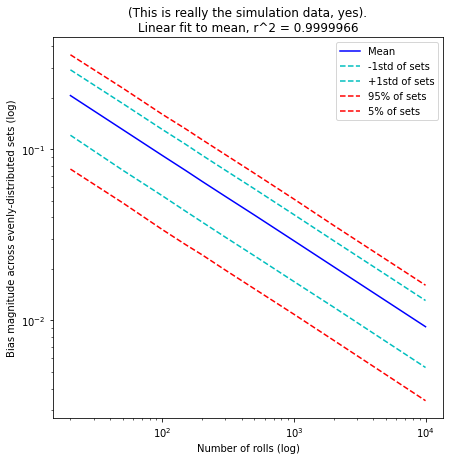

In [13]:
fig = plt.figure(figsize=[7,7])
ax = plt.subplot(111)
xtemp = np.array(setsizes)
ytemp = set_mean
ystd = set_std
yrange05 = set_05
yrange95 = set_95
ax.plot(xtemp, ytemp, 'b', 
        xtemp, ytemp+ystd, 'c--', 
        xtemp, ytemp-ystd, 'c--', 
        xtemp, yrange05, 'r--',
        xtemp, yrange95, 'r--',
       )
ax.set_yscale('log')
ax.set_xscale('log')

xtemp2 = xtemp.reshape(-1,1) #reshape to a nx1 vector (flatten)
ytemp2 = ytemp.reshape(-1,1)
ystd2 = ystd.reshape(-1,1)
yrange05_2 = yrange05.reshape(-1,1)
yrange95_2 = yrange95.reshape(-1,1)

model = LinearRegression().fit(np.log(xtemp2), np.log(ytemp2))
modelup = LinearRegression().fit(np.log(xtemp2), np.log(ytemp2+ystd2))
modeldn = LinearRegression().fit(np.log(xtemp2), np.log(ytemp2-ystd2))
modelup2 = LinearRegression().fit(np.log(xtemp2), np.log(yrange95_2))
modeldn2 = LinearRegression().fit(np.log(xtemp2), np.log(yrange05_2))

ax.set_title('(This is really the simulation data, yes).\nLinear fit to mean, r^2 = {0:.7f}'.format(model.score(np.log(xtemp2), np.log(ytemp2))))
fits_set = np.zeros([5,2])
fits_set[0,:] = (np.concatenate([modeldn2.coef_[0], modeldn2.intercept_]))
fits_set[1,:] = (np.concatenate([modeldn.coef_[0], modeldn.intercept_]))
fits_set[2,:] = (np.concatenate([model.coef_[0], model.intercept_]))
fits_set[3,:] = (np.concatenate([modelup.coef_[0], modelup.intercept_]))
fits_set[4,:] = (np.concatenate([modelup2.coef_[0], modelup2.intercept_]))

#Data is a near-perfect fit, suggesting that 1) We definitely
#could have properly calculated the expected bias, BUT 2) The
#numerical approximation is very good. In other words, we can
#predict how much bias we'd expect at any number of rolls, not
#just the tested sets. 


plt.legend(['Mean', '-1std of sets', '+1std of sets', '95% of sets', '5% of sets'])
plt.xlabel('Number of rolls (log)')
plt.ylabel('Bias magnitude across evenly-distributed sets (log)')
plt.show()

In [14]:
def bias_range(nrolls, fits_set):
    """
    Inputs: Number of rolls, set of linear fit equations.
    Outputs the expected range of bias vector variance, using the above
    fit equations to extrapolate for the given number of rolls 'nrolls'
    """
    biasvec_range = []
    for n in np.arange(fits_set.shape[0]):
        biasvec_range.append(np.exp(fits_set[n,0]*np.log(nrolls) + fits_set[n,1]))
    
    #The inner numbers (.05, -1 stdev) are largely useless. Only use mean,
    #+1 stdev, or 0.95, biasvec_range[2:]. 
    
    #Why? They assume that the data is normal, when the data is a one-sided normal,
    #BIG difference!
    
    return biasvec_range[2:]

In [15]:
biasvec_range = bias_range(75,fits_set)

#My plan was to use this value to estimate the likelihood of a given
#bias vector for a given set of rolls was. However, because the bias 
#vector isn't as informative as I hoped, I'll be focusing on other 
#analyses. 

biasvec_range

[0.10643537166872995, 0.15106781657881646, 0.18576016423059535]

In [16]:
bias_range(len(test_dice), fits_set)

#In other words, for the given set of rolls, you'd expect a bias
#vector with magnitude .03, up to .05 at the most. 

[0.02913414212814555, 0.04141868831223214, 0.05097087497517952]

In [ ]:
# #DISPLAY WITH VECTORS:
# fig = plt.figure(figsize=[10,10])
# ax = fig.add_subplot(111, projection='3d')
# for n in range(20):
#     ax.plot(xs=[fv[n,0],fv[n,0]], ys=[fv[n,1],fv[n,1]], zs=[-1,fv[n,2]], 
#             marker='x', color='gray', linestyle='--')
#     ax.plot(xs=[0,fv[n,0]], ys=[0,fv[n,1]], zs=[0,fv[n,2]],
#             marker='s', linestyle='-')
#     ax.text(x=fv[n,0], y=fv[n,1], z=fv[n,2], s=num_str[n])

# ax.plot(xs=[ov_big[0],ov_big[0]], 
#         ys=[ov_big[1],ov_big[1]], 
#         zs=[-1, ov_big[2]], 
#         marker='x', color='gray', linestyle='--')
# ax.plot(xs=[0,ov_big[0]], ys=[0,ov_big[1]], zs=[0,ov_big[2]],
#         marker='*', markersize=15, linestyle='-', color='r')
# ax.text(x=ov_big[0], y=ov_big[1], z=ov_big[2], s='Est. bias\ndirection')
# plt.show()

In [29]:
#DISPLAY THE DICE, FUNCTION

def display_dice(dice_set, use_offset=True, use_offsetvec=False, cmap='rdbu_r', biasvec=False):
    '''Outputs the relative weight of each face for a given set of rolls'''

    rng.shuffle(dice_set.values)
    test_hist, test_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    outvec = np.matmul(test_hist.T, fv)/len(dice_set)
    num_str = [str(tempnum) for tempnum in range(1,21)]
    ov_mag = np.sqrt(np.sum(np.square(outvec)))
    ov_big = outvec/ov_mag

    #Vectors for showing the data:

    #Put in the vector of points in x,y,z; then put in the
    #point indices (i.e. point 0, point 1, etc.) that make
    #up the individual triangles. This is basically how I 
    #built the 'fa' face angles vector in the first place,
    #so I just copied the 'va' indices from that.


    #Draw the shape (color for frequency of face selection):
    tri_i = [0,6,0,2,8,2,0,4,1,5,1,6,1,2,7,3,0,8,0,4]
    tri_j = [1,8,3,10,9,3,7,5,2,6,2,7,9,4,8,4,5,10,1,6]
    tri_k = [9,11,5,11,10,4,9,6,3,7,10,8,10,11,9,5,7,11,3,11]

    tri_int = test_hist

    tri_x = va_cart[:,0]
    tri_y = va_cart[:,1]
    tri_z = va_cart[:,2]
    
    #Build the dice faces:
    fig = go.Figure(data=[
        go.Mesh3d(
            x=tri_x, 
            y=tri_y, 
            z=tri_z,
            colorscale=cmap,
            cmax= 2*len(dice_set)/20, cmin=0,
            #Max at double standard likelihood, 
            #min at zero for equal color weights
            i=tri_i,
            j=tri_j,
            k=tri_k,
            intensity = tri_int,
            intensitymode = 'cell',
            lighting=dict(ambient=1)
        )])
    
    
    #Set offset properties for all above-face markers:
    scale_facevec = 20/len(dice_set)
    scale_foffset = 0.9
    
    #Add the expected-value markers:
    
    #Expected value dots:
    temp_x3 = fv[:,0]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    temp_y3 = fv[:,1]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    temp_z3 = fv[:,2]*(scale_foffset+(len(dice_set)/20)*scale_facevec)
    
    #Expected value vectors:
    temp_x = zip(fv[:,0]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,0]*scale_foffset, [None] * 20)
    temp_x4 = []
    for temptup in temp_x:
        temp_x4 = temp_x4 + list(temptup)
    temp_x4 = np.array(temp_x4)
    temp_y = zip(fv[:,1]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,1]*scale_foffset, [None] * 20)
    temp_y4 = []
    for temptup in temp_y:
        temp_y4 = temp_y4 + list(temptup)
    temp_y4 = np.array(temp_y4)
    temp_z = zip(fv[:,2]*(scale_foffset+len(dice_set)/20*scale_facevec), fv[:,2]*scale_foffset, [None] * 20)
    temp_z4 = []
    for temptup in temp_z:
        temp_z4 = temp_z4 + list(temptup)
    temp_z4 = np.array(temp_z4)
    
    #Plot them if requested:
    if use_offset:
        fig.add_trace(go.Scatter3d(x=temp_x3, y=temp_y3, z=temp_z3,
                                   mode='markers',
                                   marker={'color':'darkgray',
                                           'symbol':'circle',
                                           'size':6}))
        if use_offsetvec:
            fig.add_trace(go.Scatter3d(x=temp_x4, y=temp_y4, z=temp_z4,
                                       mode='lines',
                                       line={'width':2,
                                             'color':'darkgray',
                                             'dash':'dot'}))

    #Draw a path that goes along every edge:
    all_edge_vertpath = [0,1,3,0,5,3,2,4,3,5,4,6,5,7,6,8,7,0,9,7,8,9,1,10,8,11,10,2,11,4,6,11,10,9,1,2]
    tri_x_alledges = tri_x[all_edge_vertpath]
    tri_y_alledges = tri_y[all_edge_vertpath]
    tri_z_alledges = tri_z[all_edge_vertpath]

    fig.add_trace(go.Scatter3d(x=tri_x_alledges, 
                               y=tri_y_alledges, 
                               z=tri_z_alledges,
                               mode='lines',
                               name='vertices',
                               marker=dict(
                                   size=12,
                                   color=1,
                                   opacity=1
                               )
                              ))

    #Draw the bias vector:
    if biasvec:
        fig.add_trace(go.Scatter3d(x=[0,ov_big[0]],y=[0,ov_big[1]],z=[0,ov_big[2]],
                                   text=['','Bias point'], 
                                   textposition='top center',
                                   marker={'size':5,
                                           'symbol':'diamond',
                                           'color':'green',
                                          }
                                  ))


    
    #Build a vector to show frequency for each face (toss in "None"s
    #between to split each vector from the next within a single scatter
    #plot call):
    
    for n in range(20):
        fig.add_trace(go.Scatter3d(x=[fv[n,0]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,0]*scale_foffset*0.92],
                                   y=[fv[n,1]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,1]*scale_foffset*0.92],
                                   z=[fv[n,2]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,2]*scale_foffset*0.92],
                                   mode='markers',
                                   #mode='lines+markers',
                                   #line={'width': 17,
                                   #      'color': 'black',
                                   #     },
                                   marker={'size': 4,
                                           'color': [test_hist[n]*scale_facevec,test_hist[n]*scale_facevec],
                                           'colorscale': cmap,
                                           'cmax': 2,
                                           'cmin': 0,
                                           #'line':{'color':'black', 'width':4}
                                          }
                                  ))
        fig.add_trace(go.Scatter3d(x=[fv[n,0]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,0]*scale_foffset*0.92],
                                   y=[fv[n,1]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,1]*scale_foffset*0.92],
                                   z=[fv[n,2]*(scale_foffset+test_hist[n]*scale_facevec), fv[n,2]*scale_foffset*0.92],
                                   mode='lines+markers',
                                   line={'width': 16,
                                         'color': [test_hist[n]*scale_facevec,test_hist[n]*scale_facevec],
                                         'colorscale': cmap,
                                         'cmax': 2,
                                         'cmin': 0
                                        },
                                   marker={'size': 3,
                                           'color': [test_hist[n]*scale_facevec,test_hist[n]*scale_facevec],
                                           'colorscale': cmap,
                                           'cmax': 2,
                                           'cmin': 0
                                          }
                                  ))
    
    #Label the faces, on the end of each scale vec:
    labels_scalevec = 0.2 + scale_foffset+test_hist*scale_facevec
    labelmin = 0.2 + scale_foffset+(len(dice_set)/20)*scale_facevec
    labels_scalevec[labels_scalevec < labelmin] = labelmin
    fig.add_trace(go.Scatter3d(x=fv[:,0]*labels_scalevec,
                               y=fv[:,1]*labels_scalevec,
                               z=fv[:,2]*labels_scalevec,
                               text=num_str,
                               textfont=dict(
                                   family="sans serif",
                                   size=20,
                                   color='darkblue'
                               ),
                               mode='text',
                               textposition="middle center"
                              ))
    
    #     #Label the faces (on the face):
    #     fig.add_trace(go.Scatter3d(x=fv[:,0]*1.1, y=fv[:,1]*1.1, z=fv[:,2]*1.1,
    #                                text=num_str,
    #                                textfont=dict(
    #                                    family="sans serif",
    #                                    size=20,
    #                                    color='darkblue'
    #                                ),
    #                                mode='text',
    #                                textposition="middle center"
    #                               ))

    fig.update_layout(showlegend=False)

    fig.show()
    

In [30]:
display_dice(test_dice.iloc[:,0], cmap='rdbu_r')
# display_dice(test_dice_2.iloc[:-1,3])

#Not bad, but the face vectors could be better. Maybe need an outline.

#Also, should be uniform color for any spots that are within expected
#variance. Only color up the ones outside it!

Looks good!

And stats-wise... looking at Dice 0, the bias vector is the little green thing (if "biasvec" input is set to True). It doesn't seem to be a helpful indicator of which faces have more rolls. Offsetting a sphere has the same problem. Either is *accurate*, but not very *useful*, because the dice is biased by face geometry, not weight. The edges are visibly less sharp around the opposite side from face 7. There is still enough bias toward one side that they do tell you something, like pointing away from the cold spot on Dice 0, but the displayed dice does better.

Next steps: 

1) Use a sphere to display the likelihood instead of a dice? The smoothness might make the face bias and hot/cold spots a lot easier to see, and it would be a good chance to learn how to map and smooth data onto a surface.  
2) Histogram sorted by frequency, compare to randomly-generated sets of rolls. This will be a good way to distinguish visually between random error and systematic bias. DONE, see below.

So! Long story short, I am reasonably sure that dice 0 (the Orange dice) is somewhat biased, given the large difference between the sides, and the fact that there is a clear order to it. However, that order is not what I was expecting. It looks like there's a cold spot, but instead of the corresponding higher areas being on the opposite side from the cold spot (like you might expect if the dice was heavier on one side), the hottest spots are right around the edge. This suggests that rather than having a weight imbalance, it has an edge imbalance. Perhaps the edges around 7 (opposite 14), may be less pronounced. This would lead to the dice tending to continue rolling, rather than stopping with that face down. 

In [ ]:
#Known from dice:
test_set_1 = test_dice.iloc[:,0]
test_set_2 = test_dice.iloc[:,1]
test_hist_1, test_bins = np.histogram(test_set_1, bins=np.arange(0.5,21.5))
test_hist_2, test_bins = np.histogram(test_set_2, bins=test_bins)

test_hist_1_inds = np.argsort(test_hist_1)
test_hist_1 = np.sort(test_hist_1)
test_hist_2_inds = np.argsort(test_hist_2)
test_hist_2 = np.sort(test_hist_2)

In [ ]:
#So we have a set of histogram data that we want to get an average
#between... what I should really do here is see whether the graphs
#are comparable between the different roll-number scales

all_testset.shape

#This set is 100000x10x20, number of sets x which setsize (setsizes) x face

In [ ]:
#Scaling based on my orange dice, get the potential range
histrange = int(np.ceil(np.sum(test_hist_1) * 0.1))

#For the test set, we want to sort so that the faces are ordered by
#how often each one happened, not by number. The face number itself
#is not relevant, since in this simulation they are equally likely.
#We just want the likelihood that SOME face is higher or lower than
#a given value. 

#Sort the testset by most-likely to least-likely face
all_testset_sort = np.sort(all_testset, axis=2) #sort along face axis

In [ ]:
# #Re-histogram: Get histograms for each face for each nrolls

# #Note: Sometimes true_divide warnings, since there are zeros,
# #but it works fine.

# target_set = 4
# histset = []
# #for each of 10 types of test set,
# for n in range(10):
#     histtemp = []
#     #For each of 20 numbers,
#     for m in range(20):
#         #Generate the histogram for that number
#         temporary_histogram, binstemp = np.histogram(all_testset_sort[:,n,m], bins=np.arange(0.5,histrange+1.5))
#         histtemp.append(temporary_histogram/sum(temporary_histogram))
#     histset.append(histtemp)

In [ ]:
n,m = 0,0
temporary_histogram, binstemp = np.histogram(all_testset_sort[:,n,m], bins=np.arange(0.5,histrange+1.5))
# histtemp.append(temporary_histogram/sum(temporary_histogram))

In [ ]:
plt.plot(all_testset_sort[:,0,11])

In [ ]:
def plot_dice_hist(dice_set, modeled_set, setsizes):
    
    #Process the dice data:
    test_hist, test_bins = np.histogram(dice_set, bins=np.arange(0.5,21.5))
    test_hist_inds = np.argsort(test_hist)
    test_hist = np.sort(test_hist)
    
    #Set the max range on the histogram to half of total rolls:
    histrange = int(np.ceil(np.sum(test_hist) * 0.5))
    
    #Build a test histogram that is scaled to the number of dice rolls:
    nrolls = len(dice_set)
    nsets = modeled_set.shape[0]
    
    test_hist_bulk = []
    for n in range(numsets):
        test_hist_bulk.append(all_testset[n,7,:])

    test_hist_bulk = np.sort(np.array(test_hist_bulk).squeeze(),axis=1)
    test_hist_out = []
    for n in range(20):
        temphist = np.histogram(test_hist_bulk[:,n], bins=np.arange(0.5,histrange+1.5))
        test_hist_out.append(temphist[0])
    
    test_hist_model = []
    for n in range(nsets):
        test_hist_model.append(modeled_set[n,5,:])
    test_hist_model = np.sort(np.array(test_hist_model).squeeze(),axis=1)
    
    test_hist_out = []
    for n in range(20):
        temphist = np.histogram(test_hist_bulk[:,n], bins=np.arange(0.5,histrange+1.5))
        test_hist_out.append(temphist[0])

    test_hist_out = np.array(test_hist_out).squeeze().astype(float)
    test_hist_out_nans = np.copy(test_hist_out)
    test_hist_out_nans[test_hist_out_nans==0] = np.nan



    plt.figure(figsize=[10,10])
    ax = plt.subplot(111)
    ax.plot(test_hist_out_nans.T/np.max(test_hist_out,axis=1) + np.tile(np.arange(0,20),[histrange,1]),'k')
    ax.set_yticks(range(20))
    ax.set_yticklabels(['Least common'] + ['']*18 + ['Most common'])
    ax.set_ylabel('Dice face, after sorting by how often it appears')
    ax.set_xlabel('How often each face appears in 10000 randomly generated rolls (blue = mean)')
    ax.plot(np.array([test_hist_1, test_hist_1]), np.array([np.arange(0,20), np.arange(1,21)]), 'r')
    temp_maxes = np.argmax(test_hist_out, axis=1)
    temp_means = np.matmul(test_hist_out, np.arange(histrange))/np.nansum(test_hist_out, axis=1)
    plt.plot(np.array([temp_means, temp_means]), np.array([np.arange(0,20), np.arange(1,21)]), 'b')
    #Label by likelihood:
    for n in range(20):
        offset_var = test_hist_1[n] - temp_means[n]
        offset_var = -1*histrange*(int(offset_var<0) - 0.25)*0.04
        n_likelihood = np.sum(test_hist_out[n,:test_hist_1[n]])/np.sum(test_hist_out[n,:])
        ax.text(test_hist_1[n] + offset_var, n+0.4, s='{0:.3f}'.format(n_likelihood))
        ax.text(80, n+0.25, num_str[test_hist_1_inds[n]])

    plt.title('Dice 0 verdict: Very unlikely, though still technically possible.')
    plt.show()

In [ ]:
plot_dice_hist(test_set_1, all_testset)

In [ ]:
all_testset[0,4,:]

In [ ]:
all_testset[0,5,:]

In [ ]:
#Assign appropriate comparisons based on number of rolls:
numrolls = np.sum(test_hist_2)
histrange = int(np.ceil(numrolls * 0.2)) #Set max to one fifth of total. 

test_hist_bulk = []
for n in range(numsets):
    test_hist_bulk.append(all_testset[n,7,:])
    
test_hist_bulk = np.sort(np.array(test_hist_bulk).squeeze(),axis=1)
test_hist_out = []
for n in range(20):
    temphist = np.histogram(test_hist_bulk[:,n], bins=np.arange(0.5,histrange+1.5))
    test_hist_out.append(temphist[0])
    
test_hist_out = np.array(test_hist_out).squeeze().astype(float)
test_hist_out_nans = np.copy(test_hist_out)
test_hist_out_nans[test_hist_out_nans==0] = np.nan

#Do the actual comparison:
plt.figure(figsize=[10,10])
ax = plt.subplot(111)
ax.plot(test_hist_out_nans.T/np.max(test_hist_out,axis=1) + np.tile(np.arange(0,20),[histrange,1]),'k')
ax.set_yticks(range(20))
ax.set_yticklabels(['Least common'] + ['']*18 + ['Most common'])
ax.set_ylabel('Dice face, after sorting by how often it appears')
ax.set_xlabel('How often each face was rolled, across 100000 randomly generated sets of {0} rolls (blue = mean)'.format(numrolls))
ax.plot(np.array([test_hist_2, test_hist_2]), np.array([np.arange(0,20), np.arange(1,21)]), 'r')
temp_maxes = np.argmax(test_hist_out, axis=1)
temp_means = np.matmul(test_hist_out, np.arange(histrange))/np.nansum(test_hist_out, axis=1)
plt.plot(np.array([temp_means, temp_means]), np.array([np.arange(0,20), np.arange(1,21)]), 'b')
#Label by likelihood:
for n in range(20):
    offset_var = test_hist_2[n] - temp_means[n]
    offset_var = -1*histrange*(int(offset_var<0) - 0.25)*0.04
    n_likelihood = np.sum(test_hist_out[n,:test_hist_2[n]])/np.sum(test_hist_out[n,:])
    ax.text(test_hist_2[n] + offset_var, n+0.4, s='{0:.3f}'.format(n_likelihood))
    ax.text(80, n+0.25, num_str[test_hist_2_inds[n]])
    
plt.title('Dice 1 verdict: Only slightly unlikely')
plt.show()

In [ ]:
np.round(temp_means,1)

In [ ]:
test_hist_1.astype(float)

In [ ]:
plt.plot(temp_means,'b', test_hist_1,'r')

In [ ]:
histrange

In [ ]:
test_hist_out[test_hist_out==0] = np.nan
plt.plot(test_hist_out[0,:])

In [ ]:
test_hist_out[0:10,15:30]

In [ ]:
test_hist_out[0:10,15:30]

In [ ]:
np.array([test_hist_1,test_hist_1,np.repeat(np.NaN,20)])


In [ ]:
np.tile(np.arange(0,20),[3,1]).shape

In [ ]:
np.array(zip(test_hist_1,test_hist_1,np.array(['NaN']*20)))

In [ ]:
temp = np.array([test_hist_1,test_hist_1,np.repeat(np.NaN,20)])
temp.shape

In [ ]:
temp

In [ ]:
['']*18

In [ ]:
np.arange(0,20)

In [ ]:
test_hist_out.T.shape